# Robustness of model (missed one train season)
We will evaluate the performance of the proposed RF model over 14 test seasons from 2014NH to 2020SH, where data of one season is excluded from model training.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import utilities   # self defined functions
import model_utilities   # self defined models
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder

# (for reproduciblility) fix the randomly generated numbers
SEED = 100
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = "AZAE970101"   # mutation matrix
Test_Seasons = [str(year)+s for year in range (2014, 2021) for s in ["NH", "SH"]]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 'virusPassCat',
                 'serumPassCat'
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'optimized_RF'   # the type of model to be used

missed_train_Seasons = ['Reference', '2013SH', '2014NH', '2014SH', '2015NH', '2015SH',  '2016NH', '2016SH',
                        '2017NH', '2017SH', '2018NH', '2018SH', '2019NH', '2019SH', '2020NH']   # missed train seasons

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig4_robustness/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
test_fn = path_result + "SuppFig4c_robustness_miss1TrainSeason.csv"   # to save performance scores for test dataset

# filenames for figures are mentioned within the codes for figures

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [ ]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Performance of the model
- For each missed season from training dataset
    - For each test season from 2014NH to 2020SH
        - Split the data into training and test datasets
        - Prepare encoded inputs (genetic difference and metadata features)
        - Train and evaluate the model
        - Compute predictive performance
        - Save the predictions
    - Compute average predictive performance

In [ ]:
'''
Missed train season
'''
for missed_train_season in missed_train_Seasons:
    
    '''
    Test Seasons
    '''
    # to collect actuals and predictions for micro-averaged scores over all test seasons
    actual_all  = {}
    predict_all = {}

    # loop through test seasons
    for test_season in Test_Seasons:
        print("Missed train season: ", missed_train_season,
              "%,   test season: ", test_season)

        '''
        Train Test Split
            - based on seasonal framework
            - Train: past virus isolates paired with past sera
            - Test: circulating virus isolates paired with past sera
        '''
        ind_train, ind_test = utilities.miss1TrainSeason_seasonal_trainTestSplit(data.copy(),
                                                                                test_season,
                                                                                missed_season=missed_train_season)

        # training dataset
        data_train = data.iloc[ind_train].copy()
        data_train.reset_index(drop=True, inplace=True)

        # test dataset
        data_test = data.iloc[ind_test].copy()
        data_test.reset_index(drop=True, inplace=True)


        '''
        Input features (genetic difference)
        '''
        # training dataset
        X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                               index=data_train.index,
                               columns=HA1_features)
        X_train.fillna(0, inplace=True)   # replace nan with 0

        # test dataset
        X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                               index=data_test.index,
                               columns=HA1_features)
        X_test.fillna(0, inplace=True)   # replace nan with 0


        '''
        Input features (metadata features)
        '''
        X_train_meta = data_train[meta_features].fillna('None').astype('str')
        X_test_meta  = data_test[meta_features].fillna('None').astype('str')


        # one hot encoding
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_train_meta = ohe.fit_transform(X_train_meta).toarray()
        X_test_meta = ohe.transform(X_test_meta).toarray()

        X_train = np.hstack((X_train.values, X_train_meta))
        X_test  = np.hstack((X_test.values, X_test_meta))


        del X_train_meta, X_test_meta


        '''
        Training and evaluation
        '''
        # optimized model
        model = getattr(model_utilities, f"model_{model_name}")
        results = model(X_train,
                        data_train.nht.values,
                        X_test = X_test)


        '''
        Test Scores
        '''
        cols       = ['mut_mat', 'model', 'metadata', 'missed_train_season', 'season']
        col_values = [mut_mat, model_name, metadata, f'{missed_train_season}%', test_season]
        utilities.compute_scores(data_test.nht.values, results['pred_test'], test_fn, col=cols, col_val=col_values)


        '''
        Save actuals and predictions
        '''
        actual_all[f'{test_season}']  = data_test.nht.values
        predict_all[f'{test_season}'] = results['pred_test']


        #################
        # End season loop
        #################


    '''
    Micro-average over seasons
    '''
    actual  = np.concatenate(list(actual_all.values()))
    predict = np.concatenate(list(predict_all.values()))

    # Test scores
    col_values = [mut_mat, model_name, metadata, f'{missed_train_season}%', 'Average']
    utilities.compute_scores(actual, predict, test_fn, col=cols, col_val=col_values)

    ####################################
    # loop over missed_train_Seasons end
    ####################################

## Imports and configuration for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read test scores and prepare data for plots

In [5]:
scores = pd.read_csv(test_fn)
scores = scores[["missed_train_season", "season", "MAE"]]

'''
for heatmap change to matrix form
'''
df = scores.pivot(index='missed_train_season', columns='season', values='MAE')

mask = np.ones_like(df[df.index!="Reference"])
mask[np.triu_indices_from(mask)] = False

# difference of MAE values w.r.t Reference
diff_df = df - df[df.index=="Reference"].to_numpy()

## Plot heatmap of difference of MAE values w.r.t reference vs. test seasons

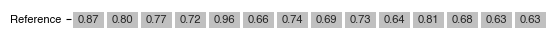

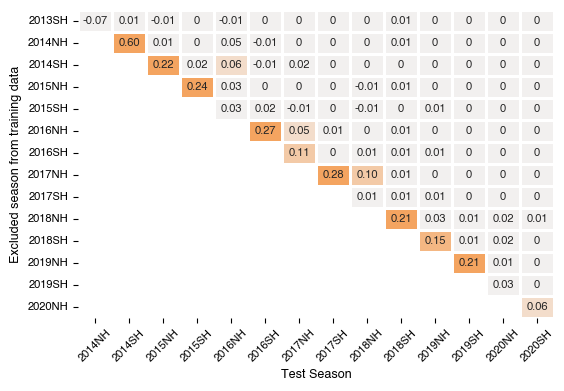

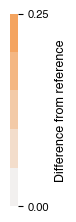

In [6]:
# Reference
fig, ax = plt.subplots(figsize=(6.14,0.25))

tmp = sns.heatmap(df[df.index == 'Reference'],
                  annot=True, annot_kws={"size":8}, fmt='.2f',
                  vmin=0,
                  vmax=0,
                  cmap=ListedColormap(['silver']),
                  cbar=False,
                  linewidths=1,
                  ax=ax)

tmp.tick_params(bottom=False)
tmp.set_xticklabels("")
tmp.set_yticklabels(["Reference"], rotation=0)

ax.set_xlabel("")
ax.set_ylabel("")


fig_fn = path_result + "SuppFig4c_Reference_NoMissedTrainSeason_heatmap.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')


# missed train season
fig, ax = plt.subplots(figsize=(6.14,4))

fig_cbar, ax_cbar = plt.subplots(figsize=(0.1,2.5))

tmp = sns.heatmap(diff_df[diff_df.index != 'Reference'],
                  mask=mask,
                  annot=True, annot_kws={"size":8}, fmt='.2f',
                  vmin=0.0,
                  vmax=0.25,
                  cmap=sns.light_palette("sandybrown", 5),
                  cbar_ax=ax_cbar,
                  cbar_kws={"shrink":0.85, "orientation":"vertical",
                            "label": "Difference from reference"},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# update the 0.00 and -0.00 text annotations
for text in ax.texts:
    if text.get_text() == '0.00' or text.get_text() == '-0.00':
        text.set_text('0')

tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)

cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.yaxis.label.set_size(9)
cbar.ax.set_yticks([cbar.ax.get_yticks()[0], cbar.ax.get_yticks()[-1]])
# cbar.ax.xaxis.set_ticks_position('bottom')

ax.set_xlabel("Test Season", fontsize=9)
ax.set_ylabel("Excluded season from training data", fontsize=9)


fig_fn = path_result+"SuppFig4c_miss1TrainSeason_heatmap.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')


fig_cbar_fn = path_result+"SuppFig4c_miss1TrainSeason_heatmap_colorbar.svg"
fig_cbar.savefig(fig_cbar_fn, format='svg', bbox_inches='tight')